# Machine learning models to classify methylation from MSC $p$-values

> Christopher Kimmel | 9/4/2020
>
> kimmel.95@osu.edu

This notebook writes and evaluates several machine-learning classifiers to identify whether HIV strands are m6A modified at zero-based nucleotide position 8078.
Reads with known modification status were sequenced in an ONT Min-ION device, then $p$-values were extracted using Tombo's `model_sample_compare` (MSC) feature with `fisher_context=0`.
The resulting $p$-values are stored in the CSV files in this directory.

What I just wrote is probably gibberish to people outside our lab. If you're reading this and you have any questions at all, please email kimmel.95@osu.edu. I like emails.

## To-do
- [ ] Remove all references to `tables`
- [ ] Report how many items are dropped during initial dropna
- [ ] Rewrite Table of Contents and summary

## Table of Contents
* [Load Training Data](#load_training_data)
* [Explore Training Data](#explore_training_data)
* [Configure Training and Testing Framework](#configure_training_and_testing_framework)
* [Design Models](#design_models)
* [Test Models](#test_models)

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.decomposition
import sklearn.svm
import sklearn.preprocessing

import matplotlib.pyplot as plt
import matplotlib.lines
import seaborn as sns
sns.set()

## Load Training Data<a name="load_training_data"></a>

In [6]:
paths = {'pos': '082720_8079m6A_positive_fishers0.csv',
         'neg': '082720_8079m6A_negative_fishers0.csv',
         'Trizol_OLD' : '/fs/project/PAS1405/kimmel_out/varied_fisher/1/fisher_0.tombo.per_read_stats.csv',
         'f1f2' : '/fs/project/PAS1405/kimmel_out/varied_fisher/2/f1f2_subsampled_fisher_0.tombo.per_read_stats.csv'
        }

# New code
tables_dropnaed = {}
for key, path in paths.items():
    print(f'loading {path}')
    pre_dropna = pd.read_csv(
        paths[key],
        header=0,
        index_col=0,
        usecols=['read_id'] + [str(x) for x in range(8071, 8080+1)], # only extract the columns we need
    )
    post_dropna = pre_dropna.dropna()
    tables_dropnaed[key] = post_dropna
    print(f'{key} total reads before dropna: {len(pre_dropna)}')
    print(f'{key} total reads after dropna: {len(post_dropna)}')
    tables_dropnaed[key].columns = map(
        (lambda x: int(x) if x.isdecimal() else x), # Sorry
        tables_dropnaed[key].columns,
    )
    print('')

loading 082720_8079m6A_positive_fishers0.csv
pos total reads before dropna: 709
pos total reads after dropna: 708

loading 082720_8079m6A_negative_fishers0.csv
neg total reads before dropna: 643
neg total reads after dropna: 642

loading /fs/project/PAS1405/kimmel_out/varied_fisher/1/fisher_0.tombo.per_read_stats.csv
Trizol_OLD total reads before dropna: 1643
Trizol_OLD total reads after dropna: 1642

loading /fs/project/PAS1405/kimmel_out/varied_fisher/2/f1f2_subsampled_fisher_0.tombo.per_read_stats.csv
f1f2 total reads before dropna: 6883
f1f2 total reads after dropna: 3439



In [3]:
for name, tab in tables_dropnaed.items():
    print(name)
    display(tab.head())

pos


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.908730,0.819033,0.727309,0.832426,0.056014,0.016025,0.434485,0.290166,0.082475,0.543456
00bb1e66-ae04-48f1-a406-811c47a1c895,0.611121,0.000193,0.080047,0.014755,0.106225,0.916429,0.165774,0.222060,0.981883,0.650183
0126a6dc-156e-4621-af1e-f032869dc80b,0.845334,0.001125,0.708078,0.122484,0.219383,0.029931,0.159753,0.642982,0.349679,0.834660
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.735947,0.822537,0.592670,0.301647,0.198147,0.070637,0.553212,0.678010,0.209285,0.958817
0239fb65-639f-4206-99af-d1955c242ceb,0.699882,0.005003,0.994960,0.615499,0.003001,0.190562,0.609684,0.325872,0.465964,0.726206


neg


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
00a0a871-6886-45c8-a6b9-65d0ba800069,0.720210,0.789149,0.420912,0.087897,0.272514,5.317310e-01,0.661067,0.609795,0.045854,0.657107
00ecb296-3580-4d75-9d1f-a6b6fedc3e01,0.549433,0.776922,0.286839,0.978955,0.351899,9.126486e-01,0.380977,0.566955,0.298615,0.719023
012e93bb-1005-4f3b-93fd-1ea1e47ffe47,0.743258,0.264297,0.768545,0.358252,0.476503,1.423748e-01,0.160891,0.362595,0.144221,0.000053
01b83cf0-0d78-453a-8e6a-e6b2187fd32f,0.580595,0.665775,0.010144,0.758974,0.300949,7.496507e-01,0.181335,0.632513,0.076767,0.937543
01c5c647-deb2-4144-8d64-baafb7d258ad,0.490944,0.895945,0.749461,0.415461,0.127709,3.200000e-17,0.736028,0.925196,0.740035,0.520994


Trizol_OLD


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
00676bde-4b93-45bb-a850-c333e08c9927,0.532200,0.665427,0.678478,0.547065,0.092869,0.000484,0.042387,0.498844,0.108770,0.829916
009fd00a-a238-426b-a768-5ccff88e9e3d,0.553935,0.894675,0.337661,0.376462,0.394596,0.004213,0.114751,0.552572,0.619290,0.941568
00a393dd-8fca-411a-9fef-c6da3712339b,0.953388,0.771212,0.990897,0.326374,0.205801,0.468165,0.417321,0.909635,0.284905,0.915740
00b6fee3-c8d3-4fcf-9a76-3d39d7f1a14f,0.000109,0.986279,0.311922,0.284982,0.280849,0.024179,0.214000,0.332598,0.308457,0.562858
00bc4e9f-bc03-46b2-b1c9-bf99aa2021d2,0.320648,0.623505,0.949723,0.212934,0.525950,0.626632,0.609795,0.712709,0.076734,0.962698


f1f2


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
0012a9ed-268f-47af-aec5-d1ea71e2b235,0.019727,0.739870,0.170365,0.898909,0.372158,0.783309,0.416172,2.236787e-07,0.915802,0.774555
004b868e-e588-4562-8869-65620d5b93db,0.388751,0.668167,0.360188,0.756013,0.458092,0.404007,0.923377,1.684743e-01,0.055183,0.986992
0067d501-34d0-416d-85eb-6c9ac788b83d,0.598880,0.988737,0.451638,0.458173,0.973088,0.650490,0.487404,9.289784e-01,0.395905,0.954731
0068da9d-22ca-4273-a656-5a71acce6079,0.358695,0.268689,0.847203,0.676655,0.879443,0.469454,0.231389,7.861659e-01,0.847901,0.916164
00773c2c-c456-4b64-8e2c-310acd91ffb7,0.803860,0.069822,0.355055,0.728603,0.676451,0.398965,0.435421,6.060473e-02,0.144073,0.778791


In [4]:
n = len(tables_dropnaed['pos'])
index = tables_dropnaed['pos'].index
pos_labels = pd.Series(np.full((n,), 1, int), index=index)

n = len(tables_dropnaed['neg'])
index = tables_dropnaed['neg'].index
neg_labels = pd.Series(np.full((n,), 0, int), index=index)

training_labels = pd.concat([pos_labels, neg_labels])
display(training_labels)

read_id
001049b1-b30e-4442-b12e-af4ffb502dd0    1
00bb1e66-ae04-48f1-a406-811c47a1c895    1
0126a6dc-156e-4621-af1e-f032869dc80b    1
022c5d7e-be67-4dd5-8766-b7272e09ac89    1
0239fb65-639f-4206-99af-d1955c242ceb    1
                                       ..
fe7485a6-2e66-47f1-815b-972bd583aca4    0
fecaaa10-576c-4889-b76d-8e3bb1a68792    0
feff2c2e-3e56-4d72-85a7-6c78a8bbeaa1    0
ffc723d2-5a45-44fe-b2d0-530554eb6f09    0
ffec333d-c008-4948-a88b-70385772d067    0
Length: 1350, dtype: int64

## Explore Training Data<a name='explore_training_data'>

Reduce to two dimensions with PCA and plot with two colors.

/usr/local/python/3.7-2019.10/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/python/3.7-2019.10/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


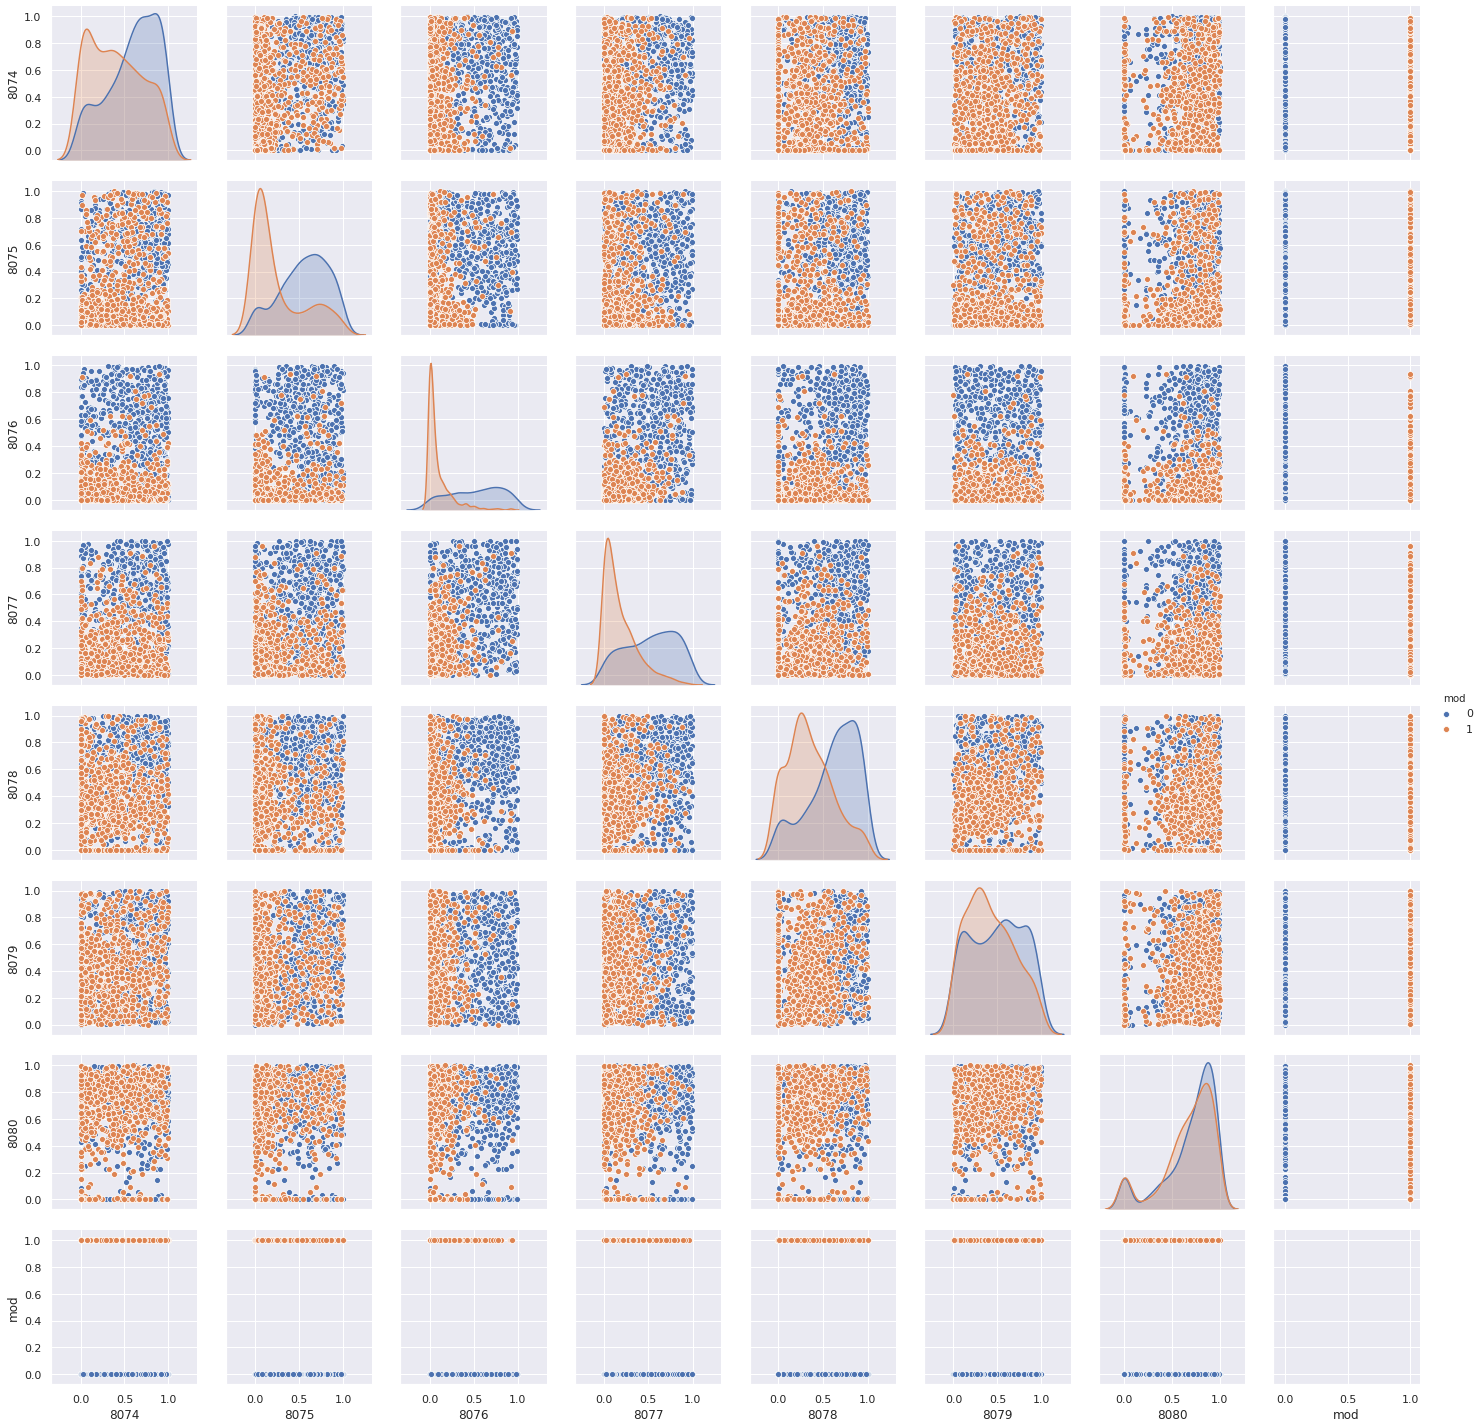

In [5]:
lo, hi = 8074, 8080
to_plot = (
    pd.concat(
        [tables_dropnaed['pos'], tables_dropnaed['neg']]
    )
    .assign(mod=training_labels)
    .loc[:, [*range(lo, hi+1)] + ['mod']]
)

sns_plot = sns.pairplot(to_plot, hue='mod')
sns_plot.savefig('pairplot.png')

In [6]:
(
    pd.concat([tables_dropnaed['pos'], tables_dropnaed['neg']])
)

,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.908730,0.819033,0.727309,0.832426,0.056014,0.016025,0.434485,0.290166,0.082475,0.543456
00bb1e66-ae04-48f1-a406-811c47a1c895,0.611121,0.000193,0.080047,0.014755,0.106225,0.916429,0.165774,0.222060,0.981883,0.650183
0126a6dc-156e-4621-af1e-f032869dc80b,0.845334,0.001125,0.708078,0.122484,0.219383,0.029931,0.159753,0.642982,0.349679,0.834660
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.735947,0.822537,0.592670,0.301647,0.198147,0.070637,0.553212,0.678010,0.209285,0.958817
0239fb65-639f-4206-99af-d1955c242ceb,0.699882,0.005003,0.994960,0.615499,0.003001,0.190562,0.609684,0.325872,0.465964,0.726206
...,...,...,...,...,...,...,...,...,...,...
fe7485a6-2e66-47f1-815b-972bd583aca4,0.763787,0.192113,0.500462,0.595861,0.175142,0.635956,0.093604,0.598011,0.073168,0.528793
fecaaa10-576c-4889-b76d-8e3bb1a68792,0.225264,0.493378,0.734564,0.587567,0.668571,0.976204,0.027672,0.819617,0.264074,0.763034
feff2c2e-3e56-4d72-85a7-6c78a8bbeaa1,0.382975,0.632045,0.609480,0.789779,0.608523,0.357777,0.884019,0.640690,0.575116,0.345352


In [7]:
x = pd.concat([tables_dropnaed['pos'], tables_dropnaed['neg']])
y = training_labels
print('x')
display(x)
print('y')
display(y)

x


,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080
read_id,,,,,,,,,,
001049b1-b30e-4442-b12e-af4ffb502dd0,0.908730,0.819033,0.727309,0.832426,0.056014,0.016025,0.434485,0.290166,0.082475,0.543456
00bb1e66-ae04-48f1-a406-811c47a1c895,0.611121,0.000193,0.080047,0.014755,0.106225,0.916429,0.165774,0.222060,0.981883,0.650183
0126a6dc-156e-4621-af1e-f032869dc80b,0.845334,0.001125,0.708078,0.122484,0.219383,0.029931,0.159753,0.642982,0.349679,0.834660
022c5d7e-be67-4dd5-8766-b7272e09ac89,0.735947,0.822537,0.592670,0.301647,0.198147,0.070637,0.553212,0.678010,0.209285,0.958817
0239fb65-639f-4206-99af-d1955c242ceb,0.699882,0.005003,0.994960,0.615499,0.003001,0.190562,0.609684,0.325872,0.465964,0.726206
...,...,...,...,...,...,...,...,...,...,...
fe7485a6-2e66-47f1-815b-972bd583aca4,0.763787,0.192113,0.500462,0.595861,0.175142,0.635956,0.093604,0.598011,0.073168,0.528793
fecaaa10-576c-4889-b76d-8e3bb1a68792,0.225264,0.493378,0.734564,0.587567,0.668571,0.976204,0.027672,0.819617,0.264074,0.763034
feff2c2e-3e56-4d72-85a7-6c78a8bbeaa1,0.382975,0.632045,0.609480,0.789779,0.608523,0.357777,0.884019,0.640690,0.575116,0.345352


y


read_id
001049b1-b30e-4442-b12e-af4ffb502dd0    1
00bb1e66-ae04-48f1-a406-811c47a1c895    1
0126a6dc-156e-4621-af1e-f032869dc80b    1
022c5d7e-be67-4dd5-8766-b7272e09ac89    1
0239fb65-639f-4206-99af-d1955c242ceb    1
                                       ..
fe7485a6-2e66-47f1-815b-972bd583aca4    0
fecaaa10-576c-4889-b76d-8e3bb1a68792    0
feff2c2e-3e56-4d72-85a7-6c78a8bbeaa1    0
ffc723d2-5a45-44fe-b2d0-530554eb6f09    0
ffec333d-c008-4948-a88b-70385772d067    0
Length: 1350, dtype: int64

Log-scaling the data makes the explained-variance ratio higher with fewer components.
I guess that makes sense.

Explained variance ratio: PCA of p-value tuples
[[0.23543922]
 [0.3480352 ]
 [0.4554045 ]
 [0.55365289]
 [0.64518722]
 [0.72838537]
 [0.80675856]
 [0.8775473 ]
 [0.9452154 ]
 [1.        ]]


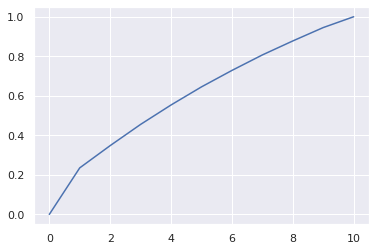

In [8]:
print('Explained variance ratio: PCA of p-value tuples')

pca_model = sklearn.decomposition.PCA()
pca_fitted = pca_model.fit(x.dropna())

evr = pca_fitted.explained_variance_ratio_.cumsum()
print(evr.reshape(-1,1))

plt.plot(np.arange(0, len(evr) + 1), np.concatenate([[0], evr]))

Explained variance ratio: PCA of log-scaled p-value tuples
[[0.63367423]
 [0.74243625]
 [0.8259087 ]
 [0.8764512 ]
 [0.91169664]
 [0.94021876]
 [0.96073096]
 [0.97749397]
 [0.99132649]
 [1.        ]]


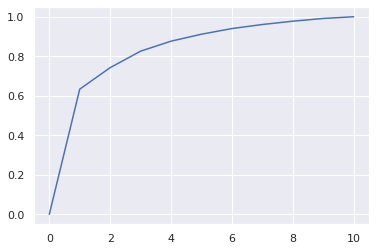

In [9]:
print('Explained variance ratio: PCA of log-scaled p-value tuples')

pca_model_log_scaled = sklearn.decomposition.PCA()
pca_fitted_log_scaled = pca_model_log_scaled.fit(np.log10(x).dropna())

evr_log_scaled = pca_fitted_log_scaled.explained_variance_ratio_.cumsum()
print(evr_log_scaled.reshape(-1,1))
plt.plot(np.arange(0, len(evr_log_scaled) + 1), np.concatenate([[0], evr_log_scaled]))

In [10]:
display(
    np.array([1, 2, 3]).reshape([-1,1]) * np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
)

array([[ 1,  2,  3],
       [ 8, 10, 12],
       [21, 24, 27]])

In [11]:
pca_fitted.explained_variance_.reshape([-1, 1])

array([[0.20646601],
       [0.09873988],
       [0.09415641],
       [0.08615792],
       [0.08027009],
       [0.07295977],
       [0.06872856],
       [0.06207746],
       [0.05934085],
       [0.04804279]])

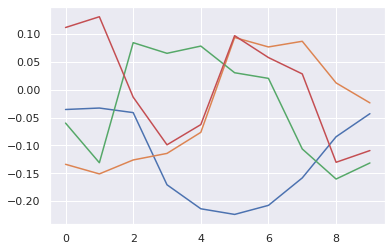

In [12]:
# components_ has shape (n_components, n_features)
# explained_variance_ has shape (n_components)

weighted_components = pca_fitted.explained_variance_.reshape([-1, 1])**(0.5) * pca_fitted.components_
weighted_components

num_comps_to_plot = 4
plt.plot(np.arange(weighted_components.shape[-1]).reshape([-1,1]), weighted_components[0:num_comps_to_plot, :].T)

In [67]:
# old code
# mean = x.dropna().values.mean(axis=0) # + pca_fitted.components_[0]

# print('\t'.join(['pos','mean','comp1','comp2','comp3']))
# for pos, mean_entry, *comps in zip(x.columns, mean, *pca_fitted.components_[0:3]):
#    print('\t'.join(['{}'] + 4*['{: 0.1f}']).format(pos, mean_entry, *comps)) #  '{}\t{: .3f}\t{: .3f}\t{: .3f}'.format(pos, mean_entry, comp1, comp2))

pos	mean	comp1	comp2	comp3
8071	 0.5	-0.1	-0.4	-0.2
8072	 0.5	-0.1	-0.5	-0.4
8073	 0.5	-0.1	-0.4	 0.3
8074	 0.5	-0.4	-0.4	 0.2
8075	 0.4	-0.5	-0.2	 0.3
8076	 0.3	-0.5	 0.3	 0.1
8077	 0.4	-0.5	 0.2	 0.1
8078	 0.5	-0.3	 0.3	-0.3
8079	 0.5	-0.2	 0.0	-0.5
8080	 0.7	-0.1	-0.1	-0.4


In [13]:
pca_transformed = {}
for name, table in tables_dropnaed.items():
    pca_transformed[name] = (
        pd.DataFrame(
            pca_fitted.transform(table),
            index=table.index
        )
        .rename_axis('comp', axis=1)
    )
pca_transformed['Trizol_OLD']

comp,0,1,2,3,4,5,6,7,8,9
read_id,,,,,,,,,,
00676bde-4b93-45bb-a850-c333e08c9927,0.435607,-0.274488,-0.006277,0.044762,-0.035034,0.145391,-0.317735,-0.047418,-0.308415,0.027034
009fd00a-a238-426b-a768-5ccff88e9e3d,0.211029,-0.223335,-0.490045,-0.083568,0.169550,0.107859,0.110089,-0.009300,-0.110873,0.011613
00a393dd-8fca-411a-9fef-c6da3712339b,-0.189678,-0.231848,-0.265748,0.446929,-0.559794,0.207945,-0.207743,-0.062672,-0.328486,0.041522
00b6fee3-c8d3-4fcf-9a76-3d39d7f1a14f,0.453096,0.025677,-0.066854,0.086631,0.520190,0.476188,0.037920,-0.053201,0.065011,-0.090433
00bc4e9f-bc03-46b2-b1c9-bf99aa2021d2,-0.297131,0.117121,0.152928,0.257912,-0.278888,0.536632,0.004688,-0.392692,-0.339182,0.024928
...,...,...,...,...,...,...,...,...,...,...
fef86d98-76e2-42e0-af1e-27f50ef7532a,0.064540,-0.688110,0.122409,0.114127,0.273221,-0.356996,-0.170945,0.055316,-0.305310,-0.019179
ff21fe8e-3ec8-4d4a-acaa-634ab659be18,0.076083,0.548051,-0.312068,-0.110969,0.401102,0.145336,-0.172000,-0.042728,0.223389,-0.147867
ff958ce8-d2a2-4456-83c5-c1205c47b7e8,-0.330704,-0.661534,0.107251,0.059439,-0.184581,-0.210331,-0.133194,-0.394614,0.333326,0.375966


In [14]:
[name for name, table in pca_transformed.items()]

['pos', 'neg', 'Trizol_OLD', 'f1f2']

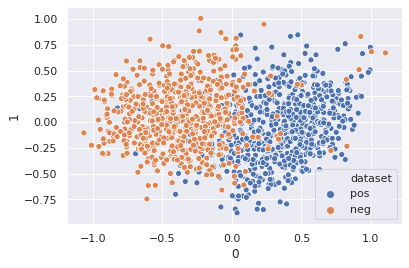

In [21]:
datasets_to_include = ['pos', 'neg']
to_plot = pd.concat(
    [(
        pca_transformed[name]
        .loc[:, 0:1]
        .rename_axis('', axis=1)
        .assign(dataset=name)
    ) for name in datasets_to_include]
)
sns.scatterplot(
    x=0,
    y=1,
    hue='dataset',
    data=to_plot,
)

## Configure Training and Testing Framework<a name='configure_training_and_testing_framework'>

In [35]:

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    pd.concat([tables_dropnaed[dataset] for dataset in ['pos', 'neg']]),
    training_labels,
    test_size=0.5,
    random_state=855
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(675, 10) (675, 10) (675,) (675,)


## Early model training

In [37]:
svm_model_linear = sklearn.svm.LinearSVC(
    penalty = 'l2',
    dual = True
)
svm_model_linear.fit(x_train, y_train)
prediction = svm_model_linear.predict(x_test)
print('error rate on test set: {:.1%}'
      .format(np.count_nonzero(prediction - y_test) / len(y_test))
     )

error rate on test set: 9.8%


Evidently the best we can do with a linear SVM is about 90% accuracy.
I'm curious what kind of accuracy we could expect from a $p$-value cutoff at just the one position.

Here's a picture.

In [39]:
# BROKEN
ax = sns.scatterplot(
    x=mean[0]+pca_transformed[0],
    y=mean[1]+pca_transformed[1],
    hue=y # y is the "target" series of correct labelings
)
co_0 = svm_model_linear.coef_[0,0]*100
co_1 = svm_model_linear.coef_[0,1]*100
b = 1/svm_model_linear.intercept_
ax.add_line(matplotlib.lines.Line2D([b-co_0,b+co_0],[b-co_1,b+co_1], color='red'))

KeyError: 0

In [40]:
# svm_model.coef_
svm_model_linear.intercept_

array([1.94635493])

Here's a nonlinear SVC. None of the kernels improve accuracy significantly, but RBF helps a little. (Note you have to scale your data before using sklearn nonlinear SVMs.)

In [47]:
'''
scaler = sklearn.preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(table.dropna().drop('mod', axis=1))
scaled_y = table.dropna()['mod']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    scaled_x, scaled_y, test_size=0.5, random_state=855
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
'''

(675, 10) (675, 10) (675,) (675,)


In [51]:
'''
svm_model_rbf = sklearn.svm.SVC(
    kernel = 'rbf'
)
svm_model_rbf.fit(x_train, y_train)
prediction = svm_model_rbf.predict(x_test)
print('error rate on test set: {:.1%}'
      .format(np.count_nonzero(prediction - y_test) / len(y_test))
     )
'''

error rate on test set: 8.7%


/usr/local/python/3.7-2019.10/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Trying model on other datasets

Now we'll take the model we trained on the labeled positive and negative control data and run it on Trizol_OLD and f1f2.

In [41]:
predictions = {}
for name, tab in tables_dropnaed.items():
    print(f'computing predictions for {name}')
    prediction = pd.Series(svm_model_linear.predict(tab), index=tab.index, dtype=int)
    predictions[name] = prediction

computing predictions for pos
computing predictions for neg
computing predictions for Trizol_OLD
computing predictions for f1f2


In [42]:
for name, tab in predictions.items():
    print(f'Dataset: {name}')
    fraction_pos = tab.sum()/len(tab)
    print(f'Fraction of reads classified as "pos": {fraction_pos:.4f}')
    print()

Dataset: pos
Fraction of reads classified as "pos": 0.9195

Dataset: neg
Fraction of reads classified as "pos": 0.0935

Dataset: Trizol_OLD
Fraction of reads classified as "pos": 0.5207

Dataset: f1f2
Fraction of reads classified as "pos": 0.1140



In [43]:
# UNCOMMENT TO WRITE RESULTS TO FILES
for name, tab in predictions.items():
    # tab.to_csv(f'./predictions/{name}_classifier_predictions.CSV')

SyntaxError: unexpected EOF while parsing (<ipython-input-43-47ac93f60668>, line 3)

## Making ROC curve

In [125]:
def diy_classifier(data, covector, intercept):
    '''
    This classifier works the same way as a linear SVM. Data is a matrix of
    shape (..., n), covector is a matrix of shape (n,), and threshold is a real
    number. `data` is dotted with `covector` along its last axis, and the
    result is True iff the result exceeds threshold.
    '''
    return np.dot(data, covector) + intercept > 0

def fpos_tpos(covector, intercept):
    '''
    This function returns a tuple `(false_positive_rate, true_positive_rate)`
    by trying `diy_classifier` on the `pos` data.
    
    THIS SCORING FUNCTION DOES NOT RESPECT THE TRAIN-TEST SPLIT.
    '''
    true_pos = diy_classifier(tables_dropnaed['pos'], covector, intercept)
    false_pos = diy_classifier(tables_dropnaed['neg'], covector, intercept)
    true_pos_rate = true_pos.mean()
    false_pos_rate = false_pos.mean()
    return false_pos_rate, true_pos_rate

In [108]:
svm_model_linear.coef_[0,0]*100
svm_model_linear.coef_[0,1]*100
svm_model_linear.intercept_

array([1.94635493])

In [109]:
svm_model_linear.coef_

array([[-0.02146705, -0.0464942 ,  0.19428969, -0.34039315, -0.92748783,
        -1.9585114 , -1.11511848, -0.80195513, -0.20149811,  0.04178002]])

In [127]:
fpos_tpos(svm_model_linear.coef_.reshape(-1), svm_model_linear.intercept_[0])

(0.09345794392523364, 0.9194915254237288)

In [146]:
threshold = np.arange(0, 4, 0.05)
fpos = np.zeros_like(threshold)
tpos = np.zeros_like(threshold)
for i in range(0, len(threshold)):
    fpos[i], tpos[i] = fpos_tpos(svm_model_linear.coef_[0, :], threshold[i])

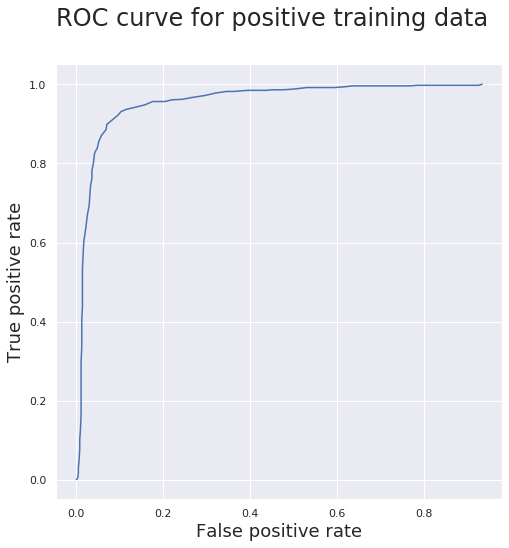

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(fpos, tpos)
ax.set_xlabel('False positive rate', fontsize=18)
ax.set_ylabel('True positive rate', fontsize=18)
fig.suptitle('ROC curve for positive training data', fontsize=24)
fig.show()
fig.savefig('ROC.png')